In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import os
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
import spacy
from sklearn.model_selection import train_test_split
from sklearn import metrics
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

In [2]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
fake = pd.read_csv("Fake.csv")
true = pd.read_csv("True.csv")

# Create category labels
fake["category"] = 1
true["category"] = 0

# Combine the datasets
df = pd.concat([fake, true]).reset_index(drop=True)

In [4]:
df.head()

,title,text,subject,date,category
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1


In [5]:
# Check for empty strings in 'text' column
blanks = []
for index, text in df["text"].items():
    if text.isspace():
        blanks.append(index)
        
# Merge 'title' with 'text' and keep only 'text' and 'category'
df["text"] = df["title"] + " " + df["text"]
df = df[["text", "category"]]

In [6]:
# Load Spacy model and create lemmatizer
nlp = spacy.load("en_core_web_sm")
lemma = WordNetLemmatizer()

In [7]:
# Create stopwords list
list1 = nlp.Defaults.stop_words
list2 = stopwords.words('english')
Stopwords = set((set(list1) | set(list2)))

In [8]:
# Define text cleaning function
def clean_text(text):
    string = ""
    text = text.lower()
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"[-()\"#!@$%^&*{}?.,:]", " ", text)
    text = re.sub(r"\s+", " ", text)
    text = re.sub('[^A-Za-z0-9]+', ' ', text)
    
    for word in text.split():
        if word not in Stopwords:
            string += lemma.lemmatize(word) + " "
    
    return string

In [9]:
df["text"] = df["text"].apply(clean_text)

In [10]:
# Tokenization and padding
max_words = 5000
max_len = 300

tokenizer = Tokenizer(num_words=max_words, lower=True)
tokenizer.fit_on_texts(df["text"])
sequences = tokenizer.texts_to_sequences(df["text"])
X = pad_sequences(sequences, maxlen=max_len)
y = df["category"].values

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [12]:
# Building the LSTM model
model = Sequential()
model.add(Embedding(max_words, 100, input_length=max_len))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:86: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [13]:
# Train Logistic Regression model
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [14]:
# Train Deep Learning Model
epochs = 5
batch_size = 64

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


Epoch 1/5
471/471 ━━━━━━━━━━━━━━━━━━━━ 362s 760ms/step - accuracy: 0.8625 - loss: 0.2759 - val_accuracy: 0.9748 - val_loss: 0.0726
Epoch 2/5
471/471 ━━━━━━━━━━━━━━━━━━━━ 357s 758ms/step - accuracy: 0.9832 - loss: 0.0550 - val_accuracy: 0.9791 - val_loss: 0.0749
Epoch 3/5
471/471 ━━━━━━━━━━━━━━━━━━━━ 362s 770ms/step - accuracy: 0.9866 - loss: 0.0438 - val_accuracy: 0.9842 - val_loss: 0.0499
Epoch 4/5
471/471 ━━━━━━━━━━━━━━━━━━━━ 389s 826ms/step - accuracy: 0.9825 - loss: 0.0537 - val_accuracy: 0.9791 - val_loss: 0.0712
Epoch 5/5
471/471 ━━━━━━━━━━━━━━━━━━━━ 394s 836ms/step - accuracy: 0.9729 - loss: 0.0753 - val_accuracy: 0.9753 - val_loss: 0.0685


In [15]:
# Mengevaluasi model ml
predictions_ml = lr_model.predict(X_test)
print(metrics.classification_report(y_test, predictions_ml))
print(f"Accuracy: {metrics.accuracy_score(y_test, predictions_ml)}")

              precision    recall  f1-score   support

           0       0.59      0.54      0.56      7039
           1       0.61      0.66      0.63      7778

    accuracy                           0.60     14817
   macro avg       0.60      0.60      0.60     14817
weighted avg       0.60      0.60      0.60     14817

Accuracy: 0.6009313626240129


In [16]:
# EMengevaluasi model deep learning
predictions = (model.predict(X_test) > 0.5).astype("int32")
print(metrics.classification_report(y_test, predictions))
print(f"Accuracy: {metrics.accuracy_score(y_test, predictions)}")


464/464 ━━━━━━━━━━━━━━━━━━━━ 52s 111ms/step
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      7039
           1       0.97      0.98      0.98      7778

    accuracy                           0.98     14817
   macro avg       0.98      0.97      0.98     14817
weighted avg       0.98      0.98      0.98     14817

Accuracy: 0.9752986434500911


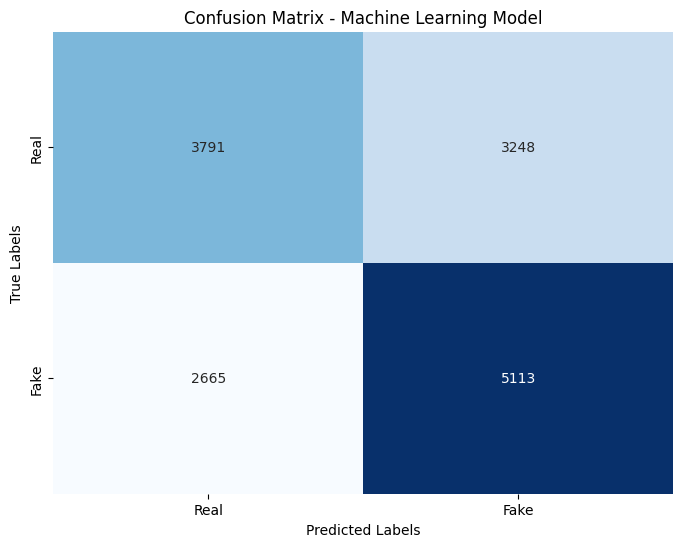

In [17]:

# Calculate confusion matrix
cm_ml = confusion_matrix(y_test, predictions_ml)

# Plot confusion matrix for machine learning model
plt.figure(figsize=(8, 6))
sns.heatmap(cm_ml, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title('Confusion Matrix - Machine Learning Model')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

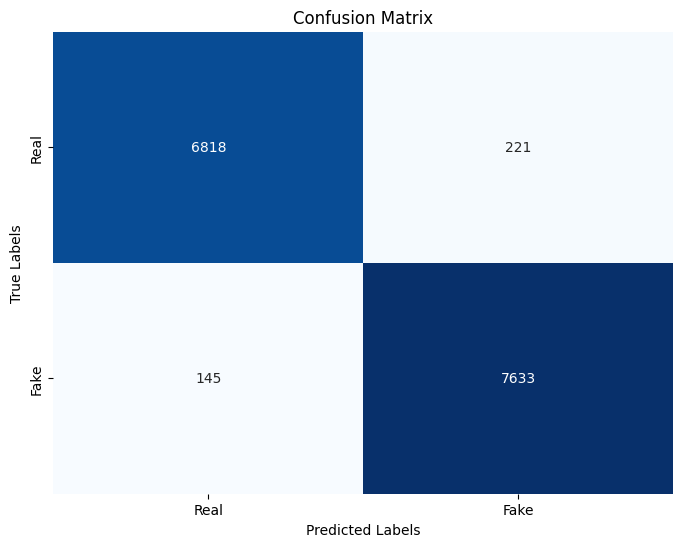

In [18]:

# Calculate confusion matrix
cm = confusion_matrix(y_test, predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title('Confusion Matrix - Deep Learning Model')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [19]:
plt.figure(figsize=(12, 5))

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

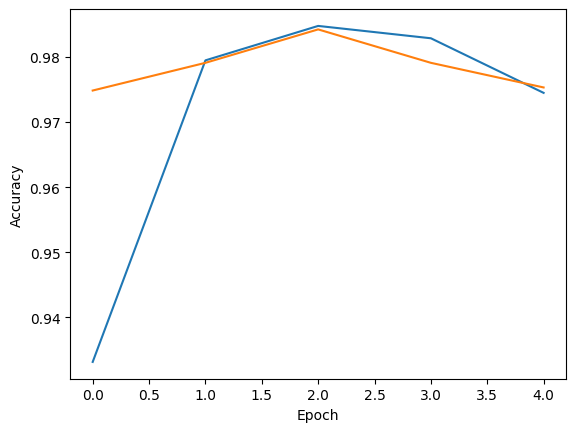

In [20]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.ylim([0, 1])
#plt.legend(loc='lower right')
plt.show()

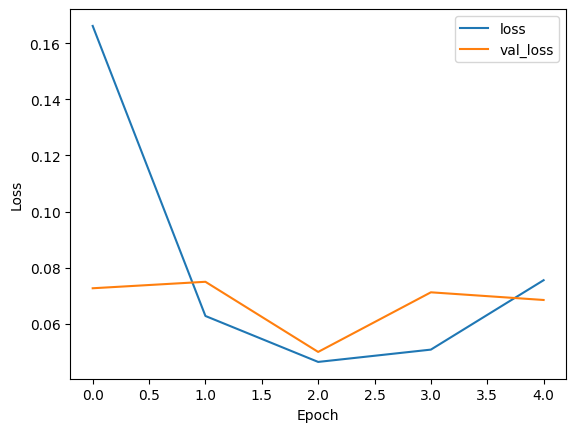

In [21]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

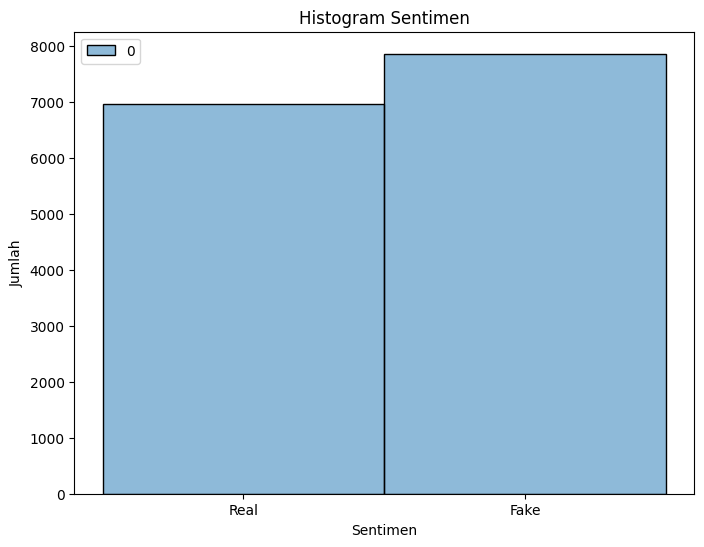

In [22]:
# Histogram Sentimen
plt.figure(figsize=(8, 6))
sns.histplot(predictions, bins=2, kde=False, color='skyblue')
plt.title('Histogram Sentimen')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah')
plt.xticks(ticks=[0.25, 0.75], labels=['Real', 'Fake'])
plt.show()

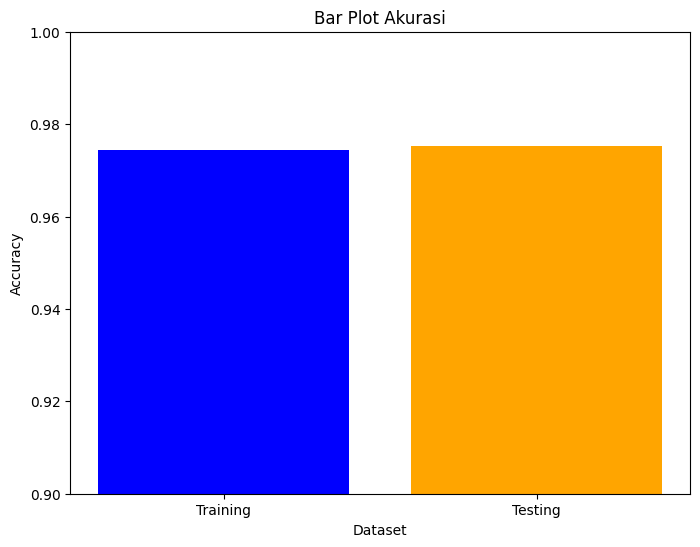

In [23]:
# Bar Plot Akurasi
train_acc = history.history['accuracy'][-1]
test_acc = metrics.accuracy_score(y_test, predictions)

plt.figure(figsize=(8, 6))
plt.bar(['Training', 'Testing'], [train_acc, test_acc], color=['blue', 'orange'])
plt.title('Bar Plot Akurasi')
plt.xlabel('Dataset')
plt.ylabel('Accuracy')
plt.ylim(0.9, 1)
plt.show()